# Visualization of the data
## H3.6m dataset

The dataset contains 17 scenarios:

In [3]:
scenarios = ["walking", "eating", "smoking", "discussion", "directions",
                    "greeting", "phoning", "posing", "purchases", "sitting",
                    "sittingdown", "takingphoto", "waiting", "walkingdog",
                    "walkingtogether"]

The actions are performed by several subjects (human actors), each of them is identified by a number:

In [4]:
subs = [
    [1, 6, 7, 8, 9], # train
    [11], # validation
    [5] # test
]

The original dataset is captured at 50Hz (1 / 20ms). We will apply a downsampling factor of 2 -> 25Hz (1 / 40ms).
10 frames are used as seed frames, and the model is trained to predict the next 10 frames. (400ms seed, 400ms prediction)


## Joint xyz coordinate format

33 joints are tracked for each frame of the sequence. The joints are identified by a number:

In [5]:
joint_name_h3m = [
    "Hips", "RightUpLeg", "RightLeg", "RightFoot", "RightToeBase", "Site", "LeftUpLeg", "LeftLeg", "LeftFoot",
    "LeftToeBase", "Site", "Spine", "Spine1", "Neck", "Head", "Site", "LeftShoulder", "LeftArm", "LeftForeArm",
    "LeftHand", "LeftHandThumb", "Site", "L_Wrist_End", "Site", "RightShoulder", "RightArm", "RightForeArm",
    "RightHand", "RightHandThumb", "Site", "R_Wrist_End", "Site"
]

Several joints are constant or are at same position with other joints, and will be ignored:

In [1]:
import numpy as np

joint_to_ignore = np.array([0, 1, 6, 11, 16, 20, 23, 24, 28, 31])

print('joints to be ignored:', np.array(joint_name_h3m)[joint_to_ignore])
print('number of joints left:', len(joint_name_h3m) - len(joint_to_ignore))

NameError: name 'joint_name_h3m' is not defined

The raw data is provided in the axis-angle format. The xyz coordinates are obtained by an exponential map, then the global rotation and translation are removed (local movement).

In [2]:
import sys
sys.path.append('/home/azhuavlev/PycharmProjects/MotionMixerConv')
from h36m.datasets import dataset_h36m, dataset_h36m_ang
%load_ext autoreload
%autoreload 2

dataset_xyz = dataset_h36m.H36M_Dataset(
    data_dir='/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses',
    input_n=100,
    output_n=100,
    skip_rate=2,
    split=0
)

RuntimeError: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

Example preprocessed batch, joint coordinates are im millimeters (mm):
_Important note_: h3.6m uses OpenCV coordinate system, which has different coordinate axes orientation:
Matplotlib: x right, y forward, z up
Opencv: x right, y down, z forward
To convert between them, we need to swap y and z axes, and negate y axis.
This does *not* affect the *training*, but is relevant for visualization.

In [ ]:
batch = dataset_xyz[0][:, dataset_xyz.dimensions_to_use]

print(batch)
print('batch.shape', batch.shape)

In [ ]:
import conv_mixer.visualization_helpers

conv_mixer.visualization_helpers.visualize_batch(dataset_xyz[100])

In [ ]:
conv_mixer.visualization_helpers.visualize_batch_single_h3m(dataset_xyz[100])

In [ ]:
from IPython.display import Video

Video("/home/azhuavlev/PycharmProjects/MotionMixerConv/conv_mixer/animation.mp4")

Animation

## Axis-angle format

The second possible format is axis-angle. Again, the global rotation and translation are removed (local movement), but we use less joints than in the xyz format. Train/validation/test splits and the number of sequences are the same.

In [ ]:
dimensions_to_use_angle = np.array(
            [6, 7, 8, 9, 12, 13, 14, 15, 21, 22, 23, 24, 27, 28, 29, 30, 36, 37, 38, 39, 40, 41, 42,
             43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 75, 76, 77, 78, 79, 80, 81, 84, 85, 86])
dimensions_to_ignore_angle = np.array(
            [0, 1, 2, 3, 4, 5, 10, 11, 16, 17, 18, 19, 20, 25, 26, 31, 32, 33, 34, 35, 48, 49, 50, 58,
              59, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
              98])
print('number of joints to use:', len(dimensions_to_use_angle) // 3)
print('number of joints to ignore:', len(dimensions_to_ignore_angle) //3)

In [ ]:
dataset_angle = dataset_h36m_ang.H36M_Dataset_Angle(
    data_dir='/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses',
    input_n=100,
    output_n=100,
    skip_rate=2,
    split=0
)

In [ ]:
batch_angle = dataset_angle[0][:, dimensions_to_use_angle]

print(batch_angle)
print('batch_angle.shape', batch_angle.shape)

## Dataset captured in AIS lab

The dataset captures 27 keypoints, of which only 19 are used. The data is provided in both xyz and axis-angle formats.

In [ ]:
joints_ais = [
    "Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", "RHip", "RKnee",
    "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar"
]
joints_ais_unused = [
    "Head", "Belly", "LBToe", "LSToe", "LHeel", "RBToe", "RSToe", "RHeel"
]

Input data format is JSON:

In [ ]:
import json

in_file_name = "/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses/2021-08-04-singlePerson_000.json"
with open(in_file_name, 'r') as f:
    pose_data = json.load(f)
pose_data[0]

Some joints have score of 0, they need to be ignored

In [ ]:
pose_data[0]['person']['keypoints'][-1]

In [ ]:
import conv_mixer.visualize_ais_data

conv_mixer.visualize_ais_data.visualize_ais_data(
    in_file_name,
    frame_start=0,
    frame_end=1000,
    frame_step=5
)

In [ ]:
Video("/home/azhuavlev/PycharmProjects/MotionMixerConv/conv_mixer/animation_ais.mp4")

In [ ]:
sys.path.append('/home/azhuavlev/PycharmProjects/MotionMixerConv')

In [3]:
from conv_mixer import datasets

In [9]:
import conv_mixer.datasets.dataset_ais_xyz as dataset_ais_xyz
dataset_ais = dataset_ais_xyz.DatasetAISxyz(
    data_dir="/home/azhuavlev/Desktop/Data/CUDA_lab/VisionLabSS23_3DPoses",
    input_n=100,
    output_n=100,
    skip_rate=1,
    actions=[
        "2021-08-04-singlePerson_003",
    ],
    smoothing_alpha=0.15
)

*********************************
Reading action 2021-08-04-singlePerson_003
Total n of frames 1067
Failed to process 0 frames
indices of failed frames: 
Current n of sequences: 867


/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when crea

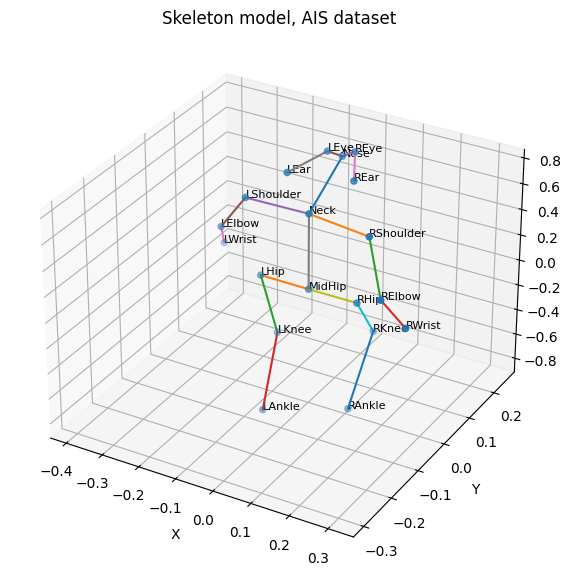

In [10]:
import conv_mixer.utils.visualization_helpers
conv_mixer.utils.visualization_helpers.visualize_batch_single_ais(dataset_ais[510])

In [14]:
# import conv_mixer.visualization_helpers
conv_mixer.utils.visualization_helpers.make_animation_ais(dataset_ais[510], add_title=True, add_joint_names=True)

/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when crea

![SegmentLocal](/home/azhuavlev/PycharmProjects/MotionMixerConv/conv_mixer/animation_ais.gif "segment")

![SegmentLocal](/home/azhuavlev/PycharmProjects/MotionMixerConv/conv_mixer/animation.gif "segment")

In [36]:
import h36m.utils.utils_mixer as utils_mixer
import torch

a = torch.rand(1, 40, 3)
b = a*0.7

print(a)
print(b)

tensor([[[0.6305, 0.1555, 0.3915],
         [0.9435, 0.5464, 0.8986],
         [0.6223, 0.7159, 0.8057],
         [0.1015, 0.1334, 0.9316],
         [0.7839, 0.3470, 0.7324],
         [0.6694, 0.8803, 0.3237],
         [0.7139, 0.3784, 0.4255],
         [0.2437, 0.9727, 0.0399],
         [0.2216, 0.8665, 0.5191],
         [0.5930, 0.7993, 0.0840],
         [0.2425, 0.3490, 0.4138],
         [0.7370, 0.6550, 0.5041],
         [0.2532, 0.7826, 0.5493],
         [0.8545, 0.0220, 0.8050],
         [0.6949, 0.5847, 0.7749],
         [0.3273, 0.1678, 0.5302],
         [0.0242, 0.3057, 0.3661],
         [0.9930, 0.3257, 0.7319],
         [0.4105, 0.4454, 0.0744],
         [0.8961, 0.6565, 0.1512],
         [0.3423, 0.4221, 0.0971],
         [0.5445, 0.7911, 0.0586],
         [0.7623, 0.7556, 0.7652],
         [0.9749, 0.0259, 0.9063],
         [0.2637, 0.4381, 0.2900],
         [0.2064, 0.2993, 0.6092],
         [0.4904, 0.0627, 0.3949],
         [0.6054, 0.1494, 0.0290],
         [0.0588, 0.

In [37]:
utils_mixer.auc_pck_metric(
   a,
    b,
)

tensor([[0.2275, 0.4239, 0.3734, 0.2840, 0.3382, 0.3457, 0.2740, 0.3011, 0.3102,
         0.2997, 0.1780, 0.3322, 0.2967, 0.3523, 0.3582, 0.1936, 0.1433, 0.3828,
         0.1831, 0.3363, 0.1656, 0.2887, 0.3954, 0.3994, 0.1763, 0.2128, 0.1898,
         0.1873, 0.2543, 0.3679, 0.3328, 0.2919, 0.2855, 0.3189, 0.3081, 0.3830,
         0.3429, 0.3398, 0.2428, 0.2798]])
tensor([[0.2275, 0.4239, 0.3734, 0.2840, 0.3382, 0.3457, 0.2740, 0.3011, 0.3102,
         0.2997, 0.1780, 0.3322, 0.2967, 0.3523, 0.3582, 0.1936, 0.1433, 0.3828,
         0.1831, 0.3363, 0.1656, 0.2887, 0.3954, 0.3994, 0.1763, 0.2128, 0.1898,
         0.1873, 0.2543, 0.3679, 0.3328, 0.2919, 0.2855, 0.3189, 0.3081, 0.3830,
         0.3429, 0.3398, 0.2428, 0.2798]])
tensor([[0.2275, 0.4239, 0.3734, 0.2840, 0.3382, 0.3457, 0.2740, 0.3011, 0.3102,
         0.2997, 0.1780, 0.3322, 0.2967, 0.3523, 0.3582, 0.1936, 0.1433, 0.3828,
         0.1831, 0.3363, 0.1656, 0.2887, 0.3954, 0.3994, 0.1763, 0.2128, 0.1898,
         0.1873, 0.2543

tensor(0.1111)